FASE 1: CARREGAMENTO E ANÁLISE EXPLORATÓRIA

✅ Dataset carregado com sucesso!
Total de amostras: 2199
Total de features: 1327

📊 DISTRIBUIÇÃO DAS CLASSES:
fileclass
0    1174
1    1025
Name: count, dtype: int64

Benignos: 1174 (53.4%)
Ransomware: 1025 (46.6%)

Proporção da classe minoritária: 46.61%
✅ Balanceamento aceitável (>30%)

📉 Esparsidade do dataset: 98.67%
   (Percentual de zeros na matriz de features)

FASE 2: DIVISÃO TREINO-TESTE ESTRATIFICADA

✅ Divisão concluída:
Treino: 1759 amostras
Teste:  440 amostras

Proporção Treino - Ransomware: 46.6%
Proporção Teste  - Ransomware: 46.6%

FASE 3: BUSCA DE HIPERPARÂMETROS (GRID SEARCH)

🔍 Testando valores de C (regularização): [0.001, 0.01, 0.1, 1.0, 10.0]
   (C pequeno = regularização forte = menos features)
   (C grande  = regularização fraca  = mais features)

⏳ Executando Grid Search (pode levar alguns minutos)...
Fitting 5 folds for each of 5 candidates, totalling 25 fits

✅ Grid Search concluído!
Melhor C: 1.0
Melhor F1-Score 

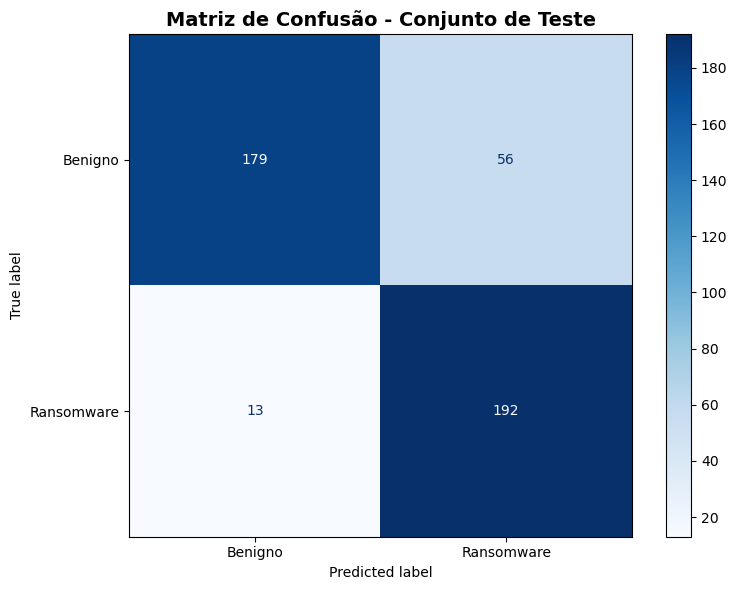


FASE 6: ANÁLISE DE FEATURES SELECIONADAS (REGULARIZAÇÃO L1)

✅ Seleção de Features concluída!
Features originais:   1327
Features selecionadas: 168
Redução:              87.3%

🏆 TOP 10 FEATURES MAIS IMPORTANTES:
------------------------------------------------------------
 1. Sleep                                    | Coef: -1.2262 | Função
 2. GetProcAddress                           | Coef: -1.0953 | Função
 3. GetCurrentProcessId                      | Coef: -0.9061 | Função
 4. GetTickCount                             | Coef: +0.8508 | Função
 5. CreateDirectoryA                         | Coef: +0.8431 | Função
 6. CreateProcessW                           | Coef: -0.8220 | Função
 7. RegCloseKey                              | Coef: -0.8160 | Função
 8. ReadFile                                 | Coef: -0.7750 | Função
 9. HeapReAlloc                              | Coef: +0.7532 | Função
10. GetModuleHandleA                         | Coef: -0.6898 | Função

💾 Lista completa salva e

In [1]:
# ========================================
# TCC NOTEBOOK - DETECÇÃO DE RANSOMWARE
# Versão Otimizada para Alta Performance
# ========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import (
    StratifiedKFold, cross_validate, GridSearchCV, 
    train_test_split
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    ConfusionMatrixDisplay, roc_auc_score, roc_curve
)
import warnings
warnings.filterwarnings('ignore')

# ========================================
# 1. CARREGAR E EXPLORAR DADOS
# ========================================

print("="*60)
print("FASE 1: CARREGAMENTO E ANÁLISE EXPLORATÓRIA")
print("="*60)

# Carregar dataset
df = pd.read_csv('base/base.csv', sep=';', encoding='utf-8')

print(f"\n✅ Dataset carregado com sucesso!")
print(f"Total de amostras: {len(df)}")
print(f"Total de features: {df.shape[1] - 2}")  # -2 (filename, fileclass)

# Separar features e target
X = df.drop(['filename', 'fileclass'], axis=1)
y = df['fileclass']

# Análise de balanceamento
print("\n📊 DISTRIBUIÇÃO DAS CLASSES:")
print(y.value_counts())
print(f"\nBenignos: {len(y[y==0])} ({len(y[y==0])/len(y)*100:.1f}%)")
print(f"Ransomware: {len(y[y==1])} ({len(y[y==1])/len(y)*100:.1f}%)")

# Calcular proporção
minority_ratio = min(len(y[y==0]), len(y[y==1])) / len(y)
print(f"\nProporção da classe minoritária: {minority_ratio:.2%}")

if minority_ratio < 0.1:
    print("⚠️ ALERTA: Desbalanceamento CRÍTICO (<10%)!")
    print("   Recomendação: Coletar mais amostras da classe minoritária")
elif minority_ratio < 0.3:
    print("⚠️ Desbalanceamento significativo (<30%)")
    print("   Estratégia: Validação Cruzada Estratificada + métricas ponderadas")
else:
    print("✅ Balanceamento aceitável (>30%)")

# Análise de esparsidade das features
sparsity = (X == 0).sum().sum() / (X.shape[0] * X.shape[1])
print(f"\n📉 Esparsidade do dataset: {sparsity:.2%}")
print("   (Percentual de zeros na matriz de features)")

# ========================================
# 2. DIVISÃO ESTRATIFICADA TREINO-TESTE
# ========================================

print("\n" + "="*60)
print("FASE 2: DIVISÃO TREINO-TESTE ESTRATIFICADA")
print("="*60)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,      # 20% para teste final
    stratify=y,         # Manter proporções
    random_state=42
)

print(f"\n✅ Divisão concluída:")
print(f"Treino: {len(X_train)} amostras")
print(f"Teste:  {len(X_test)} amostras")
print(f"\nProporção Treino - Ransomware: {(y_train==1).sum()/len(y_train)*100:.1f}%")
print(f"Proporção Teste  - Ransomware: {(y_test==1).sum()/len(y_test)*100:.1f}%")

# ========================================
# 3. OTIMIZAÇÃO DE HIPERPARÂMETROS
# ========================================

print("\n" + "="*60)
print("FASE 3: BUSCA DE HIPERPARÂMETROS (GRID SEARCH)")
print("="*60)

# Pipeline base
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(
        penalty='l1',
        solver='saga',
        max_iter=10000,  # Aumentado para garantir convergência
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'  # 🔥 IMPORTANTE: Compensa desbalanceamento
    ))
])

# Grid de hiperparâmetros
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1.0, 10.0]  # Testar múltiplos valores
}

print("\n🔍 Testando valores de C (regularização):", param_grid['classifier__C'])
print("   (C pequeno = regularização forte = menos features)")
print("   (C grande  = regularização fraca  = mais features)")

# Grid Search com Validação Cruzada Estratificada
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1_weighted',  # Métrica principal (balança precisão e recall)
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

print("\n⏳ Executando Grid Search (pode levar alguns minutos)...")
grid_search.fit(X_train, y_train)

print(f"\n✅ Grid Search concluído!")
print(f"Melhor C: {grid_search.best_params_['classifier__C']}")
print(f"Melhor F1-Score (CV): {grid_search.best_score_:.4f}")

# Exibir todos os resultados
results_df = pd.DataFrame(grid_search.cv_results_)
print("\n📊 RESULTADOS COMPLETOS DO GRID SEARCH:")
print(results_df[['param_classifier__C', 'mean_test_score', 'std_test_score']].to_string(index=False))

# ========================================
# 4. VALIDAÇÃO CRUZADA ROBUSTA COM MELHOR MODELO
# ========================================

print("\n" + "="*60)
print("FASE 4: VALIDAÇÃO CRUZADA (5-FOLDS) - MÉTRICAS DETALHADAS")
print("="*60)

best_pipeline = grid_search.best_estimator_

# Métricas para validação
scoring_metrics = {
    'accuracy': 'accuracy',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted',
    'f1_weighted': 'f1_weighted',
    'roc_auc': 'roc_auc'
}

cv_results = cross_validate(
    best_pipeline,
    X_train, y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring=scoring_metrics,
    return_train_score=False,
    n_jobs=-1
)

print("\n✅ Validação Cruzada concluída!")
print("\n📊 MÉTRICAS ROBUSTAS (Média ± Desvio Padrão):")
print("-" * 60)

metrics_summary = {}
for metric_name, scores in cv_results.items():
    if metric_name.startswith('test_'):
        clean_name = metric_name.replace('test_', '')
        mean_score = scores.mean()
        std_score = scores.std()
        metrics_summary[clean_name] = (mean_score, std_score)
        print(f"{clean_name.upper():20s}: {mean_score:.4f} ± {std_score:.4f}")

# Salvar métricas para o TCC
with open('metricas_cv.txt', 'w') as f:
    f.write("MÉTRICAS DE VALIDAÇÃO CRUZADA (5-FOLDS)\n")
    f.write("="*60 + "\n\n")
    for metric, (mean, std) in metrics_summary.items():
        f.write(f"{metric.upper()}: {mean:.4f} ± {std:.4f}\n")

print("\n💾 Métricas salvas em: metricas_cv.txt")

# ========================================
# 5. AVALIAÇÃO NO CONJUNTO DE TESTE
# ========================================

print("\n" + "="*60)
print("FASE 5: AVALIAÇÃO FINAL NO CONJUNTO DE TESTE")
print("="*60)

# Treinar modelo final no treino completo
best_pipeline.fit(X_train, y_train)

# Predições no teste
y_pred = best_pipeline.predict(X_test)
y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]

# Relatório de classificação
print("\n📊 RELATÓRIO DE CLASSIFICAÇÃO (Conjunto de Teste):")
print(classification_report(y_test, y_pred, target_names=['Benigno', 'Ransomware']))

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
print("\n🔢 MATRIZ DE CONFUSÃO:")
print(cm)

tn, fp, fn, tp = cm.ravel()
print(f"\nVerdadeiros Negativos (TN): {tn}")
print(f"Falsos Positivos    (FP): {fp}")
print(f"Falsos Negativos    (FN): {fn}")
print(f"Verdadeiros Positivos(TP): {tp}")

# Análise crítica de Falsos Negativos
if (fn + tp) > 0:
    fn_rate = fn / (fn + tp)
    print(f"\n⚠️ Taxa de Falsos Negativos: {fn_rate:.2%}")
    if fn_rate > 0.2:
        print("   ALERTA: Mais de 20% dos ransomwares NÃO foram detectados!")
    elif fn_rate > 0.1:
        print("   Atenção: 10-20% de ransomwares escaparam.")
    else:
        print("   ✅ Boa taxa de detecção (<10% de FN)")

# ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\n📈 ROC AUC Score: {roc_auc:.4f}")

# Plotar Matriz de Confusão
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Benigno', 'Ransomware']
)
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - Conjunto de Teste', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('matriz_confusao.png', dpi=300, bbox_inches='tight')
print("\n💾 Matriz de confusão salva em: matriz_confusao.png")
plt.show()

# ========================================
# 6. ANÁLISE DE FEATURES SELECIONADAS (L1)
# ========================================

print("\n" + "="*60)
print("FASE 6: ANÁLISE DE FEATURES SELECIONADAS (REGULARIZAÇÃO L1)")
print("="*60)

# Extrair coeficientes do modelo treinado
classifier = best_pipeline.named_steps['classifier']
coefficients = classifier.coef_[0]

# Identificar features selecionadas (coeficiente != 0)
feature_names = X.columns
selected_mask = coefficients != 0
selected_features = feature_names[selected_mask]
selected_coefs = coefficients[selected_mask]

n_total = len(feature_names)
n_selected = len(selected_features)
reduction_pct = (1 - n_selected/n_total) * 100

print(f"\n✅ Seleção de Features concluída!")
print(f"Features originais:   {n_total}")
print(f"Features selecionadas: {n_selected}")
print(f"Redução:              {reduction_pct:.1f}%")

# Top 10 features mais importantes (por valor absoluto do coeficiente)
top10_indices = np.argsort(np.abs(selected_coefs))[-10:][::-1]
top10_features = selected_features[top10_indices]
top10_coefs = selected_coefs[top10_indices]

print("\n🏆 TOP 10 FEATURES MAIS IMPORTANTES:")
print("-" * 60)
for i, (feat, coef) in enumerate(zip(top10_features, top10_coefs), 1):
    feat_type = "Função" if feat.startswith('func_') else "String"
    feat_clean = feat.replace('func_', '').replace('str_', '')
    print(f"{i:2d}. {feat_clean:40s} | Coef: {coef:+.4f} | {feat_type}")

# Salvar lista completa de features selecionadas
with open('features_selecionadas.txt', 'w', encoding='utf-8') as f:
    f.write(f"FEATURES SELECIONADAS PELO MODELO L1\n")
    f.write(f"Total: {n_selected} de {n_total} ({reduction_pct:.1f}% de redução)\n")
    f.write("="*60 + "\n\n")
    for feat, coef in sorted(zip(selected_features, selected_coefs), 
                             key=lambda x: abs(x[1]), reverse=True):
        f.write(f"{feat:50s} | {coef:+.6f}\n")

print("\n💾 Lista completa salva em: features_selecionadas.txt")

# ========================================
# 7. SALVAR ARTEFATOS PARA PRODUÇÃO
# ========================================

print("\n" + "="*60)
print("FASE 7: SALVAMENTO DE ARTEFATOS PARA PRODUÇÃO")
print("="*60)

# Treinar modelo final em TODOS os dados (treino + teste)
print("\n⏳ Treinando modelo final em 100% dos dados...")
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(
        penalty='l1',
        C=grid_search.best_params_['classifier__C'],
        solver='saga',
        max_iter=10000,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    ))
])

final_pipeline.fit(X, y)

# Extrair e salvar scaler e model separadamente
scaler = final_pipeline.named_steps['scaler']
model = final_pipeline.named_steps['classifier']

joblib.dump(scaler, 'malware_scaler.joblib')
joblib.dump(model, 'malware_model.joblib')

print("\n✅ Artefatos salvos com sucesso!")
print("   📁 malware_scaler.joblib  (StandardScaler)")
print("   📁 malware_model.joblib   (LogisticRegression L1)")
print("   📁 matriz_confusao.png    (Visualização)")
print("   📁 metricas_cv.txt        (Métricas de CV)")
print("   📁 features_selecionadas.txt (Lista completa)")

# ========================================
# 8. RESUMO EXECUTIVO PARA O TCC
# ========================================

print("\n" + "="*60)
print("RESUMO EXECUTIVO - PARA INCLUIR NO TCC")
print("="*60)

print(f"""
📊 DATASET:
   - Total de amostras: {len(df)}
   - Features extraídas: {n_total}
   - Benignos: {len(y[y==0])} ({len(y[y==0])/len(y)*100:.1f}%)
   - Ransomware: {len(y[y==1])} ({len(y[y==1])/len(y)*100:.1f}%)

🔧 MODELO:
   - Algoritmo: Regressão Logística com regularização L1 (Lasso)
   - Melhor C (regularização): {grid_search.best_params_['classifier__C']}
   - Features selecionadas: {n_selected} de {n_total} ({reduction_pct:.1f}% de redução)
   - Class weight: Balanced (compensa desbalanceamento)

📈 PERFORMANCE (Validação Cruzada 5-Folds):
   - Acurácia:  {metrics_summary['accuracy'][0]:.4f} ± {metrics_summary['accuracy'][1]:.4f}
   - Precisão:  {metrics_summary['precision_weighted'][0]:.4f} ± {metrics_summary['precision_weighted'][1]:.4f}
   - Recall:    {metrics_summary['recall_weighted'][0]:.4f} ± {metrics_summary['recall_weighted'][1]:.4f}
   - F1-Score:  {metrics_summary['f1_weighted'][0]:.4f} ± {metrics_summary['f1_weighted'][1]:.4f}
   - ROC AUC:   {metrics_summary['roc_auc'][0]:.4f} ± {metrics_summary['roc_auc'][1]:.4f}

🎯 TESTE FINAL:
   - Verdadeiros Positivos (TP): {tp} ransomwares detectados
   - Falsos Negativos (FN):      {fn} ransomwares NÃO detectados
   - Taxa de Detecção:           {tp/(tp+fn)*100:.1f}%
   - ROC AUC (Teste):            {roc_auc:.4f}
""")

print("\n" + "="*60)
print("✅ NOTEBOOK CONCLUÍDO COM SUCESSO!")
print("="*60)
print("\nPróximos passos:")
print("1. Revisar matriz_confusao.png")
print("2. Analisar features_selecionadas.txt")
print("3. Copiar métricas de metricas_cv.txt para o TCC")
print("4. Mover .joblib para pasta do FastAPI")
print("5. Executar Missão 3 (Produção)")